In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

import pymc3 as pm
import pandas as pd
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)
%matplotlib inline

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### コード3.1 正規分布風の分布を出力する

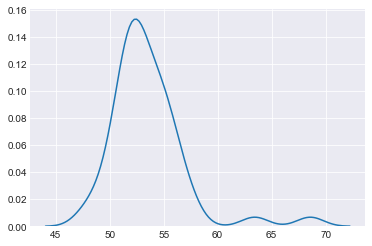

In [2]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40,
                 48.45, 52.34, 55.65, 51.49, 51.86, 63.43,
                 53.00, 56.09, 51.93, 52.31, 52.33, 57.48,
                 57.44, 55.14, 53.93, 54.62, 56.09, 68.58,
                 51.36, 55.47, 50.73, 51.94, 54.95, 50.39,
                 52.91, 51.50, 52.68, 47.72, 49.73, 51.82,
                 54.99, 52.84, 53.19, 54.52, 51.46, 53.73,
                 51.61, 49.81, 52.42, 54.30, 53.84, 53.16])
sns.kdeplot(data)

$\mu \sim Uniform(l, h)$<br>
$\sigma \sim HalfNormal(\sigma_{\sigma})$<br>
$y \sim Normal(\mu, \sigma)$

### コード3.2 正規分布の平均と標準偏差の周辺分布とトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 1600/1600 [00:01<00:00, 1133.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e8bed30>,
      dtype=object)

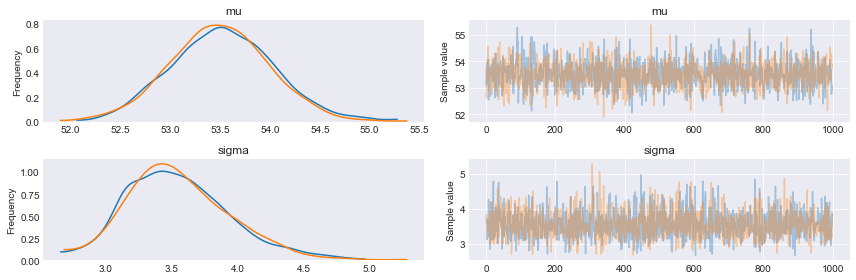

In [11]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_g = pm.sample(1100, njobs=1)
    
chain_g = trace_g[100:]
pm.traceplot(chain_g)

In [5]:
df = pm.summary(chain_g)
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.51,0.53,1.20e-02,52.42,54.51,1843.83,1.0
sigma,3.55,0.38,7.46e-03,2.84,4.30,1889.76,1.0


100%|██████████| 100/100 [00:00<00:00, 775.82it/s]
/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


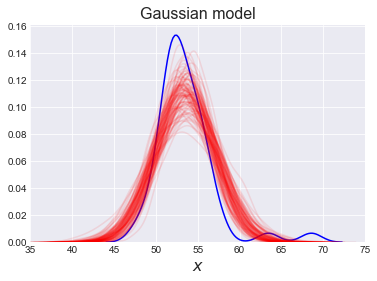

In [16]:
y_pred = pm.sample_ppc(chain_g, 100, model_g, size=len(data))
sns.kdeplot(data, c='b')
y_pred['y'] = y_pred['y'].reshape((100, -1))
for i in y_pred['y']:
    sns.kdeplot(i, c='r', alpha=0.1)
plt.xlim(35, 75)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

In [30]:
np.mean(stats.t(loc=0, scale=1, df=100).rvs(100))

-0.06644627992233501

### コード3.4 スチューデントのt分布と正規分布を出力する

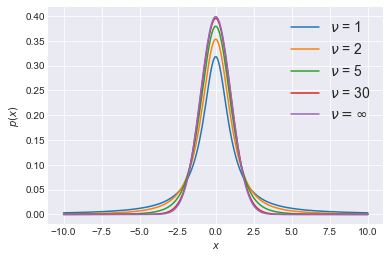

In [31]:
x_values = np.linspace(-10,10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))
    
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7)

### コード3.5 スチューデントのt分布を含むモデルのKDEとトレースプロットを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, mu]
Sampling 2 chains: 100%|██████████| 3200/3200 [00:03<00:00, 868.85draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cda17f0>,
      dtype=object)

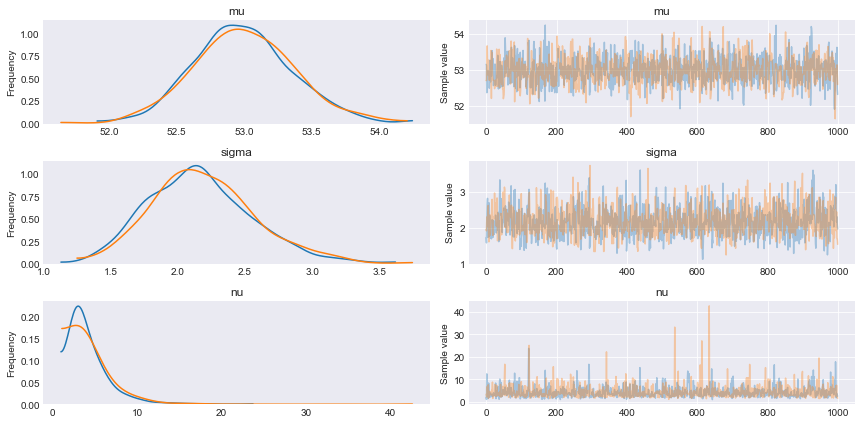

In [32]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_t = pm.sample(1100)
    
chain_t = trace_t[100:]
pm.traceplot(chain_t)

In [33]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,52.99,0.37,9.35e-03,52.30,53.78,1252.54,1.0
sigma,2.18,0.39,1.15e-02,1.43,2.94,1118.30,1.0
nu,4.40,2.78,7.49e-02,1.16,9.32,1436.37,1.0


### コード3.6 データのKDEと100組の事後予測サンプルのKDE（t分布）を出力する

100%|██████████| 100/100 [00:00<00:00, 573.82it/s]
/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


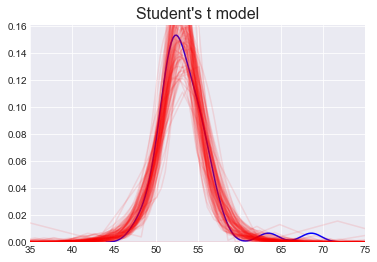

In [35]:
y_pred = pm.sample_ppc(chain_t, 100, model_t, size=len(data))
sns.kdeplot(data, c='b')
y_pred['y'] = y_pred['y'].reshape((100, -1))
for i in y_pred['y']:
    sns.kdeplot(i, c='r', alpha=0.1)
plt.xlim(35, 75)
plt.title("Student's t model", fontsize=16)

## 3.3 グループ間の比較

In [36]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


### コード3.7 チップのデータセットのヴァイオリンプロットを出力する

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


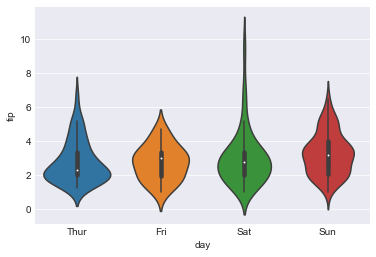

In [37]:
sns.violinplot(x='day', y='tip', data=tips)

### コード3.8 チップのデータセットのKDEとトレースプロットを出力する

In [38]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds, means]
Sampling 2 chains:  42%|████▏     | 4642/11000 [00:09<00:13, 454.93draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 11000/11000 [00:43<00:00, 148.99draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1219bfe80>,
      dtype=object)

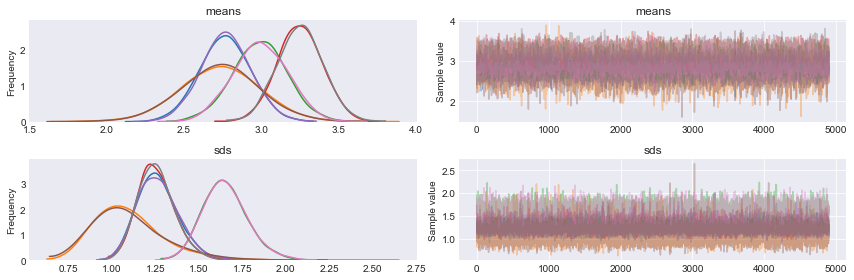

In [39]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))
    
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(5000)
    
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

In [40]:
pm.summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,2.77,0.16,1.60e-03,2.47,3.10,10614.62,1.0
means__1,2.74,0.26,2.65e-03,2.23,3.24,9181.98,1.0
means__2,2.99,0.17,1.86e-03,2.65,3.34,10941.13,1.0
means__3,3.25,0.15,1.49e-03,2.98,3.55,10307.75,1.0
sds__0,1.27,0.12,1.12e-03,1.04,1.49,10132.91,1.0
sds__1,1.10,0.20,2.29e-03,0.76,1.53,7778.96,1.0
sds__2,1.65,0.13,1.18e-03,1.41,1.91,9890.09,1.0
sds__3,1.26,0.11,1.04e-03,1.06,1.47,9819.17,1.0


### コード3.10 曜日間のチップ額の差の参照点０とHPDを出力する

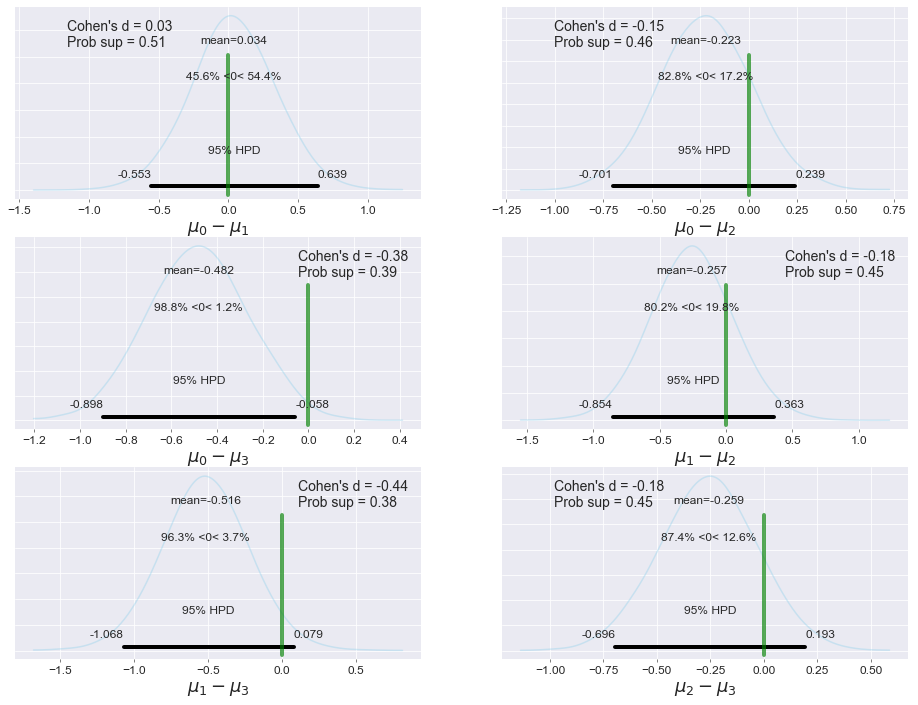

In [41]:
dist = dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i, j) for i in range(4) for j in range(i +  1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:, i] - chain_cg['means'][:, j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:, i]**2 + chain_cg['sds'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    
    # KDEプロットを表示
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], color='skyblue', kde_plot=True)
    
    # ヒストグラムを表示
    #pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], color='skyblue')
    
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k, l].legend(loc=0, fontsize=14)

### コード3.11 階層モデルのKDEとトレースプロットのを出力する（１）

In [42]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i] - G_samples[i]]))

モデルの構造<br>
$\alpha \sim HalfCauchy(\beta_{\alpha})$<br>
$\beta \sim HalfCauchy(\beta_{\beta})$<br>
$\theta \sim Beta(\alpha, \beta)$<br>
$y \sim Bern(\theta)$

### コード3.11 階層モデルのKDEとトレースプロットのを出力する（２）

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, alpha]
Sampling 2 chains:  96%|█████████▌| 4807/5000 [00:09<00:00, 536.44draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 474.56draws/s]
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120f84160>,
      dtype=object)

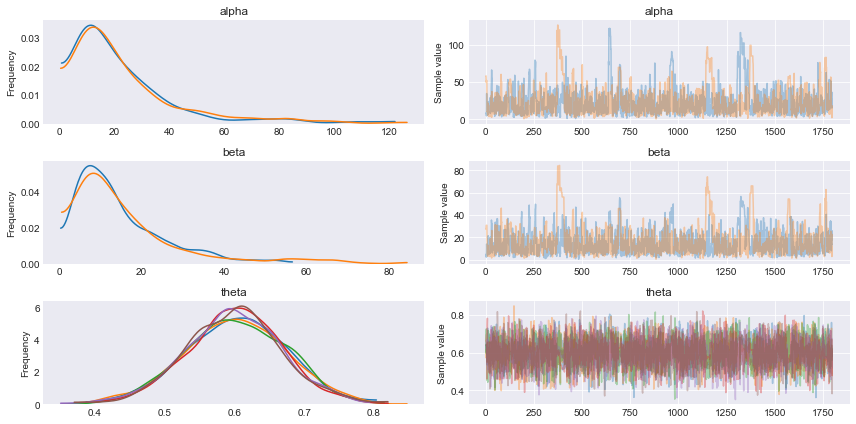

In [46]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    
    trace_h = pm.sample(2000)
chain_h = trace_h[200:]
pm.traceplot(chain_h)

In [47]:
pm.summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,23.62,19.97,1.19e+00,1.38,69.57,201.22,1.0
beta,15.64,12.63,7.48e-01,0.91,42.33,207.40,1.0
theta__0,0.60,0.07,1.63e-03,0.46,0.73,1902.03,1.0
theta__1,0.60,0.07,1.64e-03,0.46,0.75,1856.67,1.0
theta__2,0.60,0.07,1.60e-03,0.47,0.74,1941.97,1.0


### コード3.13 $\theta$の事前分布を出力する

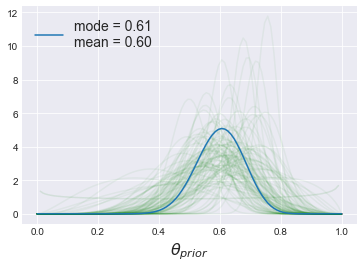

In [49]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(chain_h), size=100):
    pdf = stats.beta(chain_h['alpha'][i], chain_h['beta'][i]).pdf(x)
    plt.plot(x, pdf, 'g', alpha=0.05)
    
dist = stats.beta(chain_h['alpha'].mean(), chain_h['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel(r'$\theta_{prior}$', fontsize=16)

### 演習1

In [52]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40,
                 48.45, 52.34, 55.65, 51.49, 51.86, 63.43,
                 53.00, 56.09, 51.93, 52.31, 52.33, 57.48,
                 57.44, 55.14, 53.93, 54.62, 56.09, 68.58,
                 51.36, 55.47, 50.73, 51.94, 54.95, 50.39,
                 52.91, 51.50, 52.68, 47.72, 49.73, 51.82,
                 54.99, 52.84, 53.19, 54.52, 51.46, 53.73,
                 51.61, 49.81, 52.42, 54.30, 53.84, 53.16])
np.mean(data)

53.49645833333333

In [53]:
np.std(data)

3.4200063898474258

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 1600/1600 [00:01<00:00, 1232.66it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1237fe3c8>,
      dtype=object)

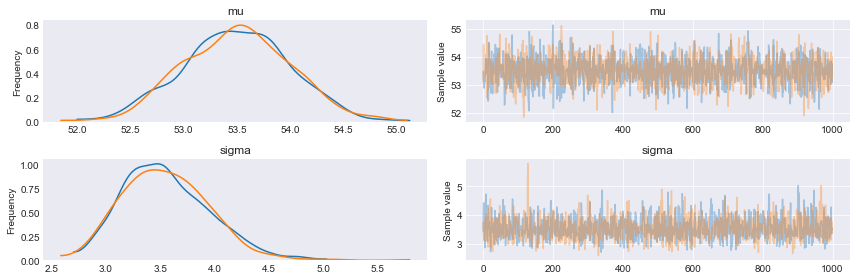

In [54]:
with pm.Model() as model_g:
    mu = pm.Normal('mu', mu=np.mean(data),sd=np.std(data))
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_g = pm.sample(1100, njobs=1)
    
chain_g = trace_g[100:]
pm.traceplot(chain_g)